# Thomas Chant
#Zestimate Improvement

In [1]:
#packages
import numpy as np
import pandas as pd
import random
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.feature_selection import SelectKBest, mutual_info_regression, RFE
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn import tree
from dtreeviz.trees import dtreeviz


In [2]:
#import the data   
train_2016 = pd.read_csv(r'C:\Users\thoma\Desktop\Colorado School of Mines\Fall 2022\DSCI470 - Introduction to Machine Learning\Final Project\train_2016_v2.csv', parse_dates=["transactiondate"]) 
train_2017 = pd.read_csv(r'C:\Users\thoma\Desktop\Colorado School of Mines\Fall 2022\DSCI470 - Introduction to Machine Learning\Final Project\train_2017.csv', parse_dates=["transactiondate"]) 
properties_2016 = pd.read_csv(r"C:\Users\thoma\Desktop\Colorado School of Mines\Fall 2022\DSCI470 - Introduction to Machine Learning\Final Project\properties_2016.csv", low_memory=False)
properties_2017 = pd.read_csv(r"C:\Users\thoma\Desktop\Colorado School of Mines\Fall 2022\DSCI470 - Introduction to Machine Learning\Final Project\properties_2017.csv", low_memory=False)
samplesubmission = pd.read_csv(r'C:\Users\thoma\Desktop\Colorado School of Mines\Fall 2022\DSCI470 - Introduction to Machine Learning\Final Project\sample_submission.csv')


In [3]:
#properties_2016
samplesubmission

,ParcelId,201610,201611,201612,201710,201711,201712
0,10754147,0,0,0,0,0,0
1,10759547,0,0,0,0,0,0
2,10843547,0,0,0,0,0,0
3,10859147,0,0,0,0,0,0
4,10879947,0,0,0,0,0,0
...,...,...,...,...,...,...,...
2985212,168176230,0,0,0,0,0,0
2985213,14273630,0,0,0,0,0,0
2985214,168040630,0,0,0,0,0,0
2985215,168040830,0,0,0,0,0,0


#import the data   
train_2016 = pd.read_csv(r'C:\Users\thoma\Desktop\Colorado School of Mines\Fall 2022\DSCI470 - Introduction to Machine Learning\Final Project\train_2016_v2.csv', parse_dates=["transactiondate"]) 
train_2017 = pd.read_csv(r'C:\Users\thoma\Desktop\Colorado School of Mines\Fall 2022\DSCI470 - Introduction to Machine Learning\Final Project\train_2017.csv', parse_dates=["transactiondate"]) 
properties_2016 = pd.read_csv(r"C:\Users\thoma\Desktop\Colorado School of Mines\Fall 2022\DSCI470 - Introduction to Machine Learning\Final Project\properties_2016.csv")
properties_2017 = pd.read_csv(r"C:\Users\thoma\Desktop\Colorado School of Mines\Fall 2022\DSCI470 - Introduction to Machine Learning\Final Project\properties_2017.csv")
samplesubmission = pd.read_csv(r'C:\Users\thoma\Desktop\Colorado School of Mines\Fall 2022\DSCI470 - Introduction to Machine Learning\Final Project\sample_submission.csv')


# Data Cleaning

The first major issue is that our y sets are much smaller than our X sets, there are loads of data points in the X set that we do not have the logerror for, so we need to get rid of those first.  This will also help massively with reducing memory issues, since instead of a ~3 million point set with 59 variables, we'll be working with less than 100,000.  Also, we need to put our 2016 and 2017 sets together.

In [4]:
def add_date_features(df):
    df["transaction_year"] = df["transactiondate"].dt.year
    df["transaction_month"] = (df["transactiondate"].dt.year - 2016)*12 + df["transactiondate"].dt.month
    df["transaction_day"] = df["transactiondate"].dt.day
    df["transaction_quarter"] = (df["transactiondate"].dt.year - 2016)*4 +df["transactiondate"].dt.quarter
    df.drop(["transactiondate"], inplace=True, axis=1)
    return df

In [5]:
properties_2016 = pd.merge(train_2016, properties_2016, how = 'left', on = 'parcelid')
properties_2017 = pd.merge(train_2017, properties_2017, how = 'left', on = 'parcelid')

properties_2016 = add_date_features(properties_2016)
properties_2017 = add_date_features(properties_2017)
test_df = properties_2016.copy()

samplesubmission['parcelid'] = samplesubmission['ParcelId']

X = pd.concat([properties_2016, properties_2017], ignore_index=True)
training = pd.concat([train_2016, train_2017], ignore_index=True)
test_df = pd.merge(properties_2016, samplesubmission[['parcelid']],  how = 'left', on = 'parcelid')
y = training.logerror


print(y.info())

<class 'pandas.core.series.Series'>
RangeIndex: 167888 entries, 0 to 167887
Series name: logerror
Non-Null Count   Dtype  
--------------   -----  
167888 non-null  float64
dtypes: float64(1)
memory usage: 1.3 MB
None


In [6]:
X.describe()

,parcelid,logerror,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock,transaction_year,transaction_month,transaction_day,transaction_quarter
count,1.678880e+05,167888.000000,53788.000000,468.000000,93.000000,167854.000000,167854.000000,31.000000,107173.000000,166056.000000,...,1.678520e+05,167854.000000,1.678510e+05,167843.000000,4683.000000,1.670020e+05,167888.000000,167888.000000,167888.000000,167888.000000
mean,1.299536e+07,0.013906,1.814345,7.299145,695.376344,2.288265,3.041739,3.967742,6.015461,2.312542,...,4.726833e+05,2015.462181,2.888805e+05,5989.515575,13.827247,6.049390e+13,2016.462290,11.032921,16.425087,4.010007
std,3.016071e+06,0.165706,2.970239,2.719633,583.952144,1.000835,1.149134,0.179605,1.882799,0.977808,...,6.028372e+05,0.498569,4.456451e+05,7214.731946,2.421658,1.054137e+12,0.498577,6.170169,8.986373,2.053449
min,1.071174e+07,-4.655420,1.000000,2.000000,38.000000,0.000000,0.000000,3.000000,1.000000,1.000000,...,2.200000e+01,2015.000000,2.200000e+01,19.920000,3.000000,6.037101e+13,2016.000000,1.000000,1.000000,1.000000
25%,1.154899e+07,-0.025300,1.000000,7.000000,280.000000,2.000000,2.000000,4.000000,4.000000,2.000000,...,2.026522e+05,2015.000000,8.373000e+04,2798.070000,13.000000,6.037312e+13,2016.000000,6.000000,9.000000,2.000000
50%,1.254060e+07,0.006000,1.000000,7.000000,588.000000,2.000000,3.000000,4.000000,7.000000,2.000000,...,3.500000e+05,2015.000000,1.977760e+05,4501.040000,14.000000,6.037604e+13,2016.000000,10.000000,16.000000,4.000000
75%,1.421930e+07,0.039200,1.000000,7.000000,819.000000,3.000000,4.000000,4.000000,7.000000,3.000000,...,5.540020e+05,2016.000000,3.553340e+05,6914.165000,15.000000,6.059042e+13,2017.000000,17.000000,24.000000,6.000000
max,1.676893e+08,5.262999,13.000000,21.000000,3560.000000,20.000000,16.000000,4.000000,12.000000,20.000000,...,4.906124e+07,2016.000000,4.895220e+07,586639.300000,99.000000,4.830301e+14,2017.000000,21.000000,31.000000,7.000000


In [7]:
X.head()

,parcelid,logerror,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,transaction_year,transaction_month,transaction_day,transaction_quarter
0,11016594,0.0276,1.0,NaN,NaN,2.0,3.0,NaN,4.0,2.0,...,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13,2016,1,1,1
1,14366692,-0.1684,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,...,2015.0,239071.0,10153.02,NaN,NaN,NaN,2016,1,1,1
2,12098116,-0.0040,1.0,NaN,NaN,3.0,2.0,NaN,4.0,3.0,...,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13,2016,1,1,1
3,12643413,0.0218,1.0,NaN,NaN,2.0,2.0,NaN,4.0,2.0,...,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13,2016,1,2,1
4,14432541,-0.0050,NaN,NaN,NaN,2.5,4.0,NaN,NaN,2.5,...,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13,2016,1,2,1


In [8]:
training.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


In [9]:
trainingvariables = ['logerror']

X = X.drop(trainingvariables, axis=1)

Next, lets examine missing values

<AxesSubplot:xlabel='Number_of_Missing_Values', ylabel='Column_Name'>

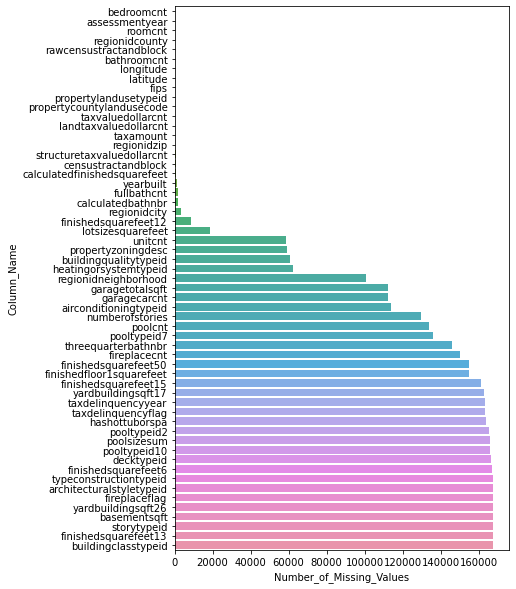

In [10]:
missingdata = X.isnull().sum(axis=0).reset_index()
missingdata.columns = ['Column_Name', 'Number_of_Missing_Values']
missingdata = missingdata.sort_values(by = 'Number_of_Missing_Values')
missingdata = missingdata[missingdata['Number_of_Missing_Values']>0]

f, ax = plt.subplots(figsize=(6, 10))
sns.set_color_codes("pastel")
sns.barplot(x="Number_of_Missing_Values", y="Column_Name", data=missingdata)

In [11]:
percent_missing = X.isnull().sum() * 100 / len(X)
bad_columns = percent_missing[percent_missing>40].keys()
X = X.drop(bad_columns, axis=1)
X.describe()
test_df = test_df.drop(bad_columns, axis = 1)

In [12]:
print(X.columns.values)

['parcelid' 'bathroomcnt' 'bedroomcnt' 'buildingqualitytypeid'
 'calculatedbathnbr' 'calculatedfinishedsquarefeet' 'finishedsquarefeet12'
 'fips' 'fullbathcnt' 'heatingorsystemtypeid' 'latitude' 'longitude'
 'lotsizesquarefeet' 'propertycountylandusecode' 'propertylandusetypeid'
 'propertyzoningdesc' 'rawcensustractandblock' 'regionidcity'
 'regionidcounty' 'regionidzip' 'roomcnt' 'unitcnt' 'yearbuilt'
 'structuretaxvaluedollarcnt' 'taxvaluedollarcnt' 'assessmentyear'
 'landtaxvaluedollarcnt' 'taxamount' 'censustractandblock'
 'transaction_year' 'transaction_month' 'transaction_day'
 'transaction_quarter']


Manually dropping redundant information variables

In [13]:
redundant_info_variables = [ 'assessmentyear', 'calculatedbathnbr', 'censustractandblock', 'finishedsquarefeet12', 'fullbathcnt', 'taxvaluedollarcnt', 'roomcnt', 'propertycountylandusecode', 'propertyzoningdesc', 'regionidcity', 'regionidcounty', 'regionidzip', 'taxamount' ]
X = X.drop(redundant_info_variables, axis=1)
test_df = test_df.drop(redundant_info_variables, axis=1)


In [14]:
print(X.columns.values)

['parcelid' 'bathroomcnt' 'bedroomcnt' 'buildingqualitytypeid'
 'calculatedfinishedsquarefeet' 'fips' 'heatingorsystemtypeid' 'latitude'
 'longitude' 'lotsizesquarefeet' 'propertylandusetypeid'
 'rawcensustractandblock' 'unitcnt' 'yearbuilt'
 'structuretaxvaluedollarcnt' 'landtaxvaluedollarcnt' 'transaction_year'
 'transaction_month' 'transaction_day' 'transaction_quarter']


In [15]:
X.describe()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,propertylandusetypeid,rawcensustractandblock,unitcnt,yearbuilt,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,transaction_year,transaction_month,transaction_day,transaction_quarter
count,1.678880e+05,167854.000000,167854.000000,107173.000000,166992.000000,167854.000000,105651.000000,1.678540e+05,1.678540e+05,1.494460e+05,167854.000000,1.678540e+05,109056.000000,166828.000000,1.673590e+05,1.678510e+05,167888.000000,167888.000000,167888.000000,167888.000000
mean,1.299536e+07,2.288265,3.041739,6.015461,1778.630246,6048.844484,3.924525,3.400678e+07,-1.182011e+08,2.951060e+04,261.828619,6.049154e+07,1.110365,1968.569311,1.843460e+05,2.888805e+05,2016.462290,11.032921,16.425087,4.010007
std,3.016071e+06,1.000835,1.149134,1.882799,940.356025,20.702187,3.642599,2.651175e+05,3.600586e+05,1.224588e+05,5.163838,2.054437e+05,0.988168,23.777202,2.192841e+05,4.456451e+05,0.498577,6.170169,8.986373,2.053449
min,1.071174e+07,0.000000,0.000000,1.000000,2.000000,6037.000000,1.000000,3.333930e+07,-1.194754e+08,1.670000e+02,31.000000,6.037101e+07,1.000000,1824.000000,4.400000e+01,2.200000e+01,2016.000000,1.000000,1.000000,1.000000
25%,1.154899e+07,2.000000,2.000000,4.000000,1183.000000,6037.000000,2.000000,3.381292e+07,-1.184130e+08,5.702000e+03,261.000000,6.037312e+07,1.000000,1953.000000,8.256800e+04,8.373000e+04,2016.000000,6.000000,9.000000,2.000000
50%,1.254060e+07,2.000000,3.000000,7.000000,1541.000000,6037.000000,2.000000,3.402170e+07,-1.181769e+08,7.200000e+03,261.000000,6.037604e+07,1.000000,1970.000000,1.340510e+05,1.977760e+05,2016.000000,10.000000,16.000000,4.000000
75%,1.421930e+07,3.000000,4.000000,7.000000,2103.000000,6059.000000,7.000000,3.417342e+07,-1.179247e+08,1.174675e+04,266.000000,6.059042e+07,1.000000,1987.000000,2.142570e+05,3.553340e+05,2017.000000,17.000000,24.000000,6.000000
max,1.676893e+08,20.000000,16.000000,12.000000,35640.000000,6111.000000,24.000000,3.481877e+07,-1.175546e+08,6.971010e+06,275.000000,6.111009e+07,237.000000,2016.000000,1.142179e+07,4.895220e+07,2017.000000,21.000000,31.000000,7.000000


Imputation Time

<AxesSubplot:xlabel='Number_of_Missing_Values', ylabel='Column_Name'>

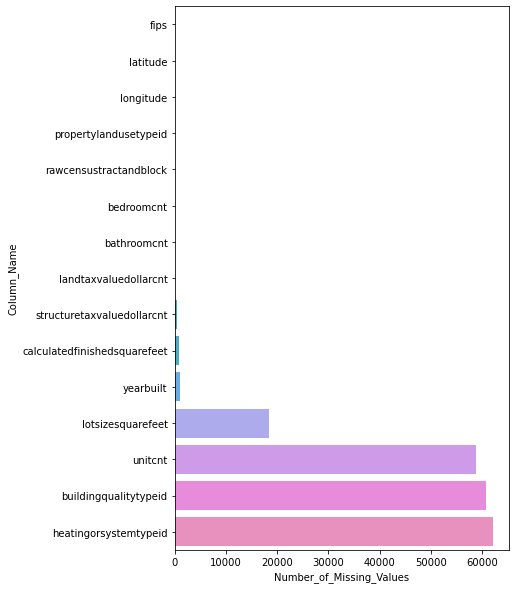

In [16]:
missingdata = X.isnull().sum(axis=0).reset_index()
missingdata.columns = ['Column_Name', 'Number_of_Missing_Values']
missingdata = missingdata.sort_values(by = 'Number_of_Missing_Values')
missingdata = missingdata[missingdata['Number_of_Missing_Values']>0]

f, ax = plt.subplots(figsize=(6, 10))
sns.set_color_codes("pastel")
sns.barplot(x="Number_of_Missing_Values", y="Column_Name", data=missingdata)

In [17]:
#Mode Imputation Pipeline and execution
listofmodeimputs = ['heatingorsystemtypeid', 'unitcnt', 'yearbuilt', 'propertylandusetypeid', 'rawcensustractandblock', 'fips']
for col in listofmodeimputs:
    X[col] = X[col].fillna(X[col].mode()[0])
    test_df[col] = test_df[col].fillna(test_df[col].mode()[0])

In [18]:
#Median Imputation Pipeline
listofmedianimputs = ['buildingqualitytypeid', 'lotsizesquarefeet', 'landtaxvaluedollarcnt', 'calculatedfinishedsquarefeet', 'structuretaxvaluedollarcnt', 'bathroomcnt', 'bedroomcnt', 'longitude', 'latitude']
for col in listofmedianimputs:
    X[col] = X[col].fillna(X[col].median())
    test_df[col] = test_df[col].fillna(test_df[col].median())

Missing values taken care of, now let's see whether anything seems to be the wrong type

In [19]:
#just double checking that test_df is correct
#missingdata = test_df.isnull().sum(axis=0).reset_index()
#missingdata.columns = ['Column_Name', 'Number_of_Missing_Values']
#missingdata = missingdata.sort_values(by = 'Number_of_Missing_Values')
#missingdata = missingdata[missingdata['Number_of_Missing_Values']>0]

#f, ax = plt.subplots(figsize=(6, 10))
#sns.set_color_codes("pastel")
#sns.barplot(x="Number_of_Missing_Values", y="Column_Name", data=missingdata)

In [20]:
print(X.dtypes)

parcelid                          int64
bathroomcnt                     float64
bedroomcnt                      float64
buildingqualitytypeid           float64
calculatedfinishedsquarefeet    float64
fips                            float64
heatingorsystemtypeid           float64
latitude                        float64
longitude                       float64
lotsizesquarefeet               float64
propertylandusetypeid           float64
rawcensustractandblock          float64
unitcnt                         float64
yearbuilt                       float64
structuretaxvaluedollarcnt      float64
landtaxvaluedollarcnt           float64
transaction_year                  int64
transaction_month                 int64
transaction_day                   int64
transaction_quarter               int64
dtype: object


Our data should be useable now, so let's poke around

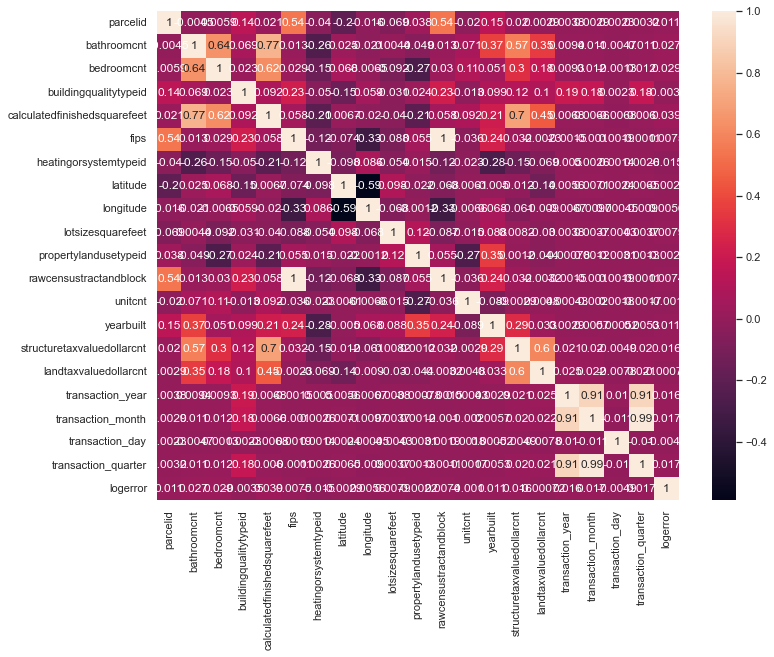

In [21]:
setwithlogerror = X.copy()
setwithlogerror['logerror'] = y

corr_matrix = setwithlogerror.corr()
sns.set(rc={'figure.figsize':(11.7,9)})
sns.heatmap(corr_matrix, annot=True)
plt.show()
#print(properties_2016.columns.values)

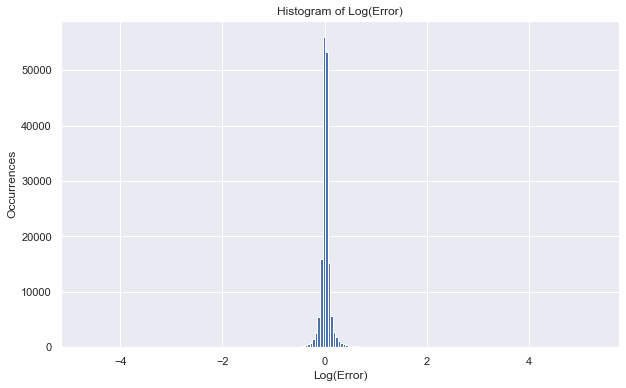

In [22]:
y.hist(bins=200, figsize=(10,6))
plt.xlabel('Log(Error)')
plt.ylabel('Occurrences')
plt.title('Histogram of Log(Error)')
plt.show()

Correlations between regressors doesn't seem to be much of an issue, but each and every regressor having a low correlation with logerror is a bit concerning.

Going to do some mutual information score examination before getting into model building

First, let's *finally* split our data into training and testing!

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [24]:
X_trainwithp = X_train.copy()
X_testwithp = X_test.copy()

X_train = X_train.drop('parcelid', axis = 1)
X_test = X_test.drop('parcelid', axis = 1)

In [25]:
k=4

mi_transformer=SelectKBest(score_func=mutual_info_regression,k=k)
mi_X_train=mi_transformer.fit_transform(X_train,y_train)
mi_X_test=mi_transformer.fit_transform(X_test,y_test)

In [26]:
for feature, importance in zip(X.columns, mi_transformer.scores_):
    print(f"The MI score for {feature} is {importance}")

The MI score for parcelid is 0.013778731807612132
The MI score for bathroomcnt is 0.008295728087625243
The MI score for bedroomcnt is 0.11837855692599808
The MI score for buildingqualitytypeid is 0.012391619604683157
The MI score for calculatedfinishedsquarefeet is 0.008856181556659237
The MI score for fips is 0.006241942296512537
The MI score for heatingorsystemtypeid is 0.02463463439586988
The MI score for latitude is 0.016216521699917053
The MI score for longitude is 0.0013354375912593142
The MI score for lotsizesquarefeet is 0.017001273379602555
The MI score for propertylandusetypeid is 0.023893772082053566
The MI score for rawcensustractandblock is 0.007626116865709243
The MI score for unitcnt is 0.02826282844163419
The MI score for yearbuilt is 0.017541310907482455
The MI score for structuretaxvaluedollarcnt is 0.00957539563597365
The MI score for landtaxvaluedollarcnt is 0.5643615044854529
The MI score for transaction_year is 0.3781700150062184
The MI score for transaction_month

In [29]:
miEst = LinearRegression().fit(mi_X_train, y_train)
print(f"The mean absolute error when training on the MI selected features is {mean_absolute_error(y_train, miEst.predict(mi_X_train))}.")
print(f"When testing on the test data, the mean absolute error is {mean_absolute_error(y_test, miEst.predict(mi_X_test))}")
mitrainmae = mean_absolute_error(y_train, miEst.predict(mi_X_train))
mitestmse = mean_absolute_error(y_test, miEst.predict(mi_X_test))

The mean absolute error when training on the MI selected features is 0.0693318770217685.
When testing on the test data, the mean absolute error is 0.06981772997544752


In [56]:
mitrainmae = []
mitestmae = []
klist =[]
mitrainmaebest = 1000
mitestmaebest = 1000
for k in range(1,7):
    mi_transformer=SelectKBest(score_func=mutual_info_regression,k=k)
    mi_X_train=mi_transformer.fit_transform(X_train,y_train)
    mi_X_test=mi_transformer.fit_transform(X_test,y_test)
    miEst = LinearRegression().fit(mi_X_train, y_train)
    mitrainmaek = mean_absolute_error(y_train, miEst.predict(mi_X_train))
    mitestmaek = mean_absolute_error(y_test, miEst.predict(mi_X_test))
    mitrainmae.append(mitrainmaek)
    mitestmae.append(mitestmaek)
    klist.append(k)
    print(f"With k = {k}, the MAE when training on the MI selected features is {mitrainmaek}.")
    print(f"With k = {k}, the MAE on the test data, the mean absolute error is {mitestmaek}")
    if mean_absolute_error(y_train, miEst.predict(mi_X_train)) < mitrainmaebest:
        mitrainmaebest = mean_absolute_error(y_train, miEst.predict(mi_X_train))
        mitestmaebest =mean_absolute_error(y_test, miEst.predict(mi_X_test))


With k = 1, the MAE when training on the MI selected features is 0.0693318770217685.
With k = 1, the MAE on the test data, the mean absolute error is 0.06981772997544752
With k = 2, the MAE when training on the MI selected features is 0.06931598214861559.
With k = 2, the MAE on the test data, the mean absolute error is 0.06980391453972094
With k = 3, the MAE when training on the MI selected features is 0.069315264046791.
With k = 3, the MAE on the test data, the mean absolute error is 0.06980574731375527
With k = 4, the MAE when training on the MI selected features is 0.06932527996705438.
With k = 4, the MAE on the test data, the mean absolute error is 0.06981881076958235
With k = 5, the MAE when training on the MI selected features is 0.06935912518934022.
With k = 5, the MAE on the test data, the mean absolute error is 0.5778381736978622
With k = 6, the MAE when training on the MI selected features is 0.06942589030516527.
With k = 6, the MAE on the test data, the mean absolute error i

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(klist, mitrainmae, label = 'Train')
plt.title('MI Training set MAE')
plt.xlabel('k')
plt.ylabel('MAE')

plt.subplot(1, 2, 2)
plt.plot(klist, mitestmae)
plt.title('Testing Set MAE')
plt.xlabel('k')
plt.ylabel('MAE')

plt.figure(figsize=(6, 4))

plt.plot(klist, mitestmae)
plt.title('Testing Set MAE')
plt.xlabel('k')
plt.ylabel('MAE')
ax = plt.gca()

ax.set_xlim([0, 6.5])
ax.set_ylim([0.0, 2])


In [31]:
rfeEst = LinearRegression()
maeest = 5
klowestmaeest = 0
rfetrainmae = []
rfetestmae = []
klistrfe =[]
for k in range(1,15):
    rfe_transformer=RFE(rfeEst,n_features_to_select=k,step=2)
    rfe_X_train=rfe_transformer.fit_transform(X_train,y_train)
    rfe_X_test=rfe_transformer.fit_transform(X_test,y_test)
    rfeEst = LinearRegression().fit(rfe_X_train, y_train)
    #print(f"With k = {k}, the MSE when training on the RFE selected features is {mean_squared_error(y_train, rfeEst.predict(rfe_X_train))}.")
    #print(f"With k = {k}, the MSE on the test data, the mean squared error is {mean_squared_error(y_test, rfeEst.predict(rfe_X_test))}")
    
    rfetrainmaek = mean_absolute_error(y_train, rfeEst.predict(rfe_X_train))
    rfetestmaek = mean_absolute_error(y_test, rfeEst.predict(rfe_X_test))
    rfetrainmae.append(rfetrainmaek)
    rfetestmae.append(rfetestmaek)
    klistrfe.append(k)
    if rfetestmaek < maeest:
        maeest = rfetestmaek
        maetrain = rfetrainmaek
        klowestmaeest = k

rfe_transformer=RFE(rfeEst,n_features_to_select=klowestmaeest,step=2)
rfe_X_train=rfe_transformer.fit_transform(X_train,y_train)
rfe_X_test=rfe_transformer.fit_transform(X_test,y_test)
rfeEst = LinearRegression().fit(rfe_X_train, y_train)        
print(f"The lowest MAE was found using k={klowestmaeest}, where the train mae was {maetrain} and the test mae was {maeest}.")
print(f"The most important features as determined by RFE were {list(X_train.columns[rfe_transformer.support_])}")
rfemaetrain = maetrain
rfemaetest = maeest

The lowest MAE was found using k=13, where the train mae was 0.06925614996508915 and the test mae was 0.06967287690845514.
The most important features as determined by RFE were ['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid', 'calculatedfinishedsquarefeet', 'fips', 'heatingorsystemtypeid', 'propertylandusetypeid', 'unitcnt', 'yearbuilt', 'transaction_year', 'transaction_month', 'transaction_day', 'transaction_quarter']


Text(0, 0.5, 'MAE')

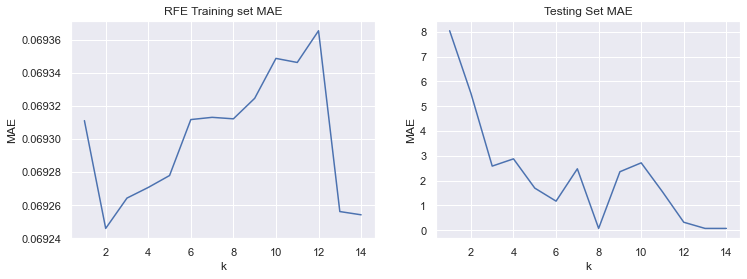

In [32]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(klistrfe, rfetrainmae)
plt.title('RFE Training set MAE')
plt.xlabel('k')
plt.ylabel('MAE')

plt.subplot(1, 2, 2)
plt.plot(klistrfe, rfetestmae)
plt.title('Testing Set MAE')
plt.xlabel('k')
plt.ylabel('MAE')

In [33]:
#plt.figure(figsize=(6, 4))
#plt.plot(klistrfe, rfetestmae)
#ax = plt.gca()
#ax.set_xlim([0, 14])
#ax.set_ylim([0.027, 0.03])
#plt.title('Testing Set MAE')
#plt.xlabel('k')
#plt.ylabel('MAE')

In [43]:
lassoEst=LassoCV(n_alphas=10).fit(X_train,y_train)
lassocoeffeaturemags = []
lassofeaturenames = []
for feature, coef in zip(X_train.columns, lassoEst.coef_):
    print(f"The magniture of the feature coefficient for {feature} is {abs(coef)}.")
    lassocoeffeaturemags.append(abs(coef))
    lassofeaturenames.append(feature)
print(f"The mean absolute error when training using lasso is {mean_absolute_error(y_train, lassoEst.predict(X_train))}.")
print(f"When testing on the test data, the mean absolute error is {mean_absolute_error(y_test, lassoEst.predict(X_test))}")
maelassotrain = mean_absolute_error(y_train, lassoEst.predict(X_train))
maelassotest = mean_absolute_error(y_test, lassoEst.predict(X_test))

The magniture of the feature coefficient for bathroomcnt is 0.0.
The magniture of the feature coefficient for bedroomcnt is 0.0.
The magniture of the feature coefficient for buildingqualitytypeid is 0.0.
The magniture of the feature coefficient for calculatedfinishedsquarefeet is 8.00765692692766e-06.
The magniture of the feature coefficient for fips is 0.0.
The magniture of the feature coefficient for heatingorsystemtypeid is 0.0.
The magniture of the feature coefficient for latitude is 1.2401988252221672e-09.
The magniture of the feature coefficient for longitude is 5.353729692043439e-09.
The magniture of the feature coefficient for lotsizesquarefeet is 1.6023571090250776e-08.
The magniture of the feature coefficient for propertylandusetypeid is 0.0.
The magniture of the feature coefficient for rawcensustractandblock is 9.00721470800527e-09.
The magniture of the feature coefficient for unitcnt is 0.0.
The magniture of the feature coefficient for yearbuilt is 0.0.
The magniture of the

In [35]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33578 entries, 90220 to 33146
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   33578 non-null  float64
 1   bedroomcnt                    33578 non-null  float64
 2   buildingqualitytypeid         33578 non-null  float64
 3   calculatedfinishedsquarefeet  33578 non-null  float64
 4   fips                          33578 non-null  float64
 5   heatingorsystemtypeid         33578 non-null  float64
 6   latitude                      33578 non-null  float64
 7   longitude                     33578 non-null  float64
 8   lotsizesquarefeet             33578 non-null  float64
 9   propertylandusetypeid         33578 non-null  float64
 10  rawcensustractandblock        33578 non-null  float64
 11  unitcnt                       33578 non-null  float64
 12  yearbuilt                     33578 non-null  float64
 1

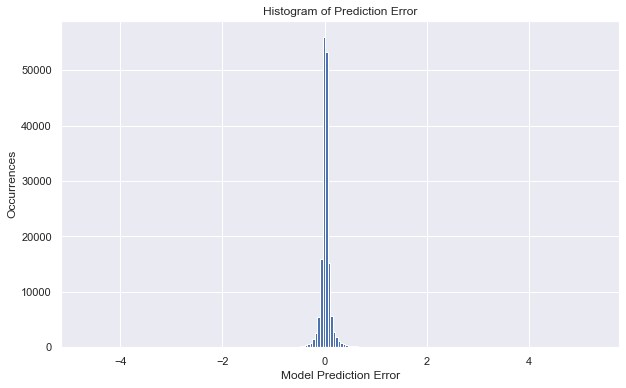

R squared training set 0.22
R squared test set 0.18


In [36]:
yhatlasso = lassoEst.predict(X_test)
lassopredminusactual = yhatlasso-y_test
parcelid = X_testwithp.parcelid

#plt.boxplot(lassopredminusactual)

y.hist(bins=200, figsize=(10,6))
plt.xlabel('Model Prediction Error')
plt.ylabel('Occurrences')
plt.title('Histogram of Prediction Error')
plt.show()

#plt.figure(figsize=(6, 4))
#plt.plot(parcelid, yhatlasso,  label = 'Predicted Log(error)')
#plt.plot(X_test, y_test, label = 'Actual Log(error)')
#plt.plot
#ax = plt.gca()
#ax.set_xlim([0, 14])
#ax.set_ylim([0.027, 0.03])
#plt.title('Testing Set MSE')
#plt.xlabel('Log(error)')
#plt.ylabel('Predicted Log(error)')

print('R squared training set', round(lassoEst.score(X_train, y_train)*100, 2))
print('R squared test set', round(lassoEst.score(X_test, y_test)*100, 2))

In [37]:
RFmodel= RandomForestRegressor(n_estimators=200,max_depth=5, min_samples_leaf=100,n_jobs=4,random_state=22)
RFmodel.fit(X_train,y_train)
y_predRF = RFmodel.predict(X_test)
print(f"The mean absolute error when training using Random Forest is {mean_absolute_error(y_train, RFmodel.predict(X_train))}.")
print(f"When testing on the test data, the mean absolute error is {mean_absolute_error(y_test, RFmodel.predict(X_test))}")

The mean absolute error when training using Random Forest is 0.06899952938090646.
When testing on the test data, the mean absolute error is 0.06949202544000915


In [38]:
rfcoeffeaturemags = []
rffeaturenames = []
for feature, coef in zip(X_train.columns, RFmodel.feature_importances_):
    print(f"The magniture of the feature coefficient for {feature} is {abs(coef)}.")
    rfcoeffeaturemags.append(abs(coef))
    rffeaturenames.append(feature)
print(f"The mean absolute error when training using random forest is {mean_absolute_error(y_train, RFmodel.predict(X_train))}.")
print(f"When testing on the test data, the mean absolute error is {mean_absolute_error(y_test, RFmodel.predict(X_test))}")
rfmaetrain = mean_absolute_error(y_train, RFmodel.predict(X_train))
rfmaetest = mean_absolute_error(y_test, RFmodel.predict(X_test))

The magniture of the feature coefficient for bathroomcnt is 0.014411847350793377.
The magniture of the feature coefficient for bedroomcnt is 0.021566366877137352.
The magniture of the feature coefficient for buildingqualitytypeid is 0.006692643411786007.
The magniture of the feature coefficient for calculatedfinishedsquarefeet is 0.3562469866811653.
The magniture of the feature coefficient for fips is 0.0.
The magniture of the feature coefficient for heatingorsystemtypeid is 0.001982374436546648.
The magniture of the feature coefficient for latitude is 0.060712102576590904.
The magniture of the feature coefficient for longitude is 0.07961152003446124.
The magniture of the feature coefficient for lotsizesquarefeet is 0.05596753691517874.
The magniture of the feature coefficient for propertylandusetypeid is 0.004570839239194539.
The magniture of the feature coefficient for rawcensustractandblock is 0.03264487041809076.
The magniture of the feature coefficient for unitcnt is 0.00827618909

<AxesSubplot:>

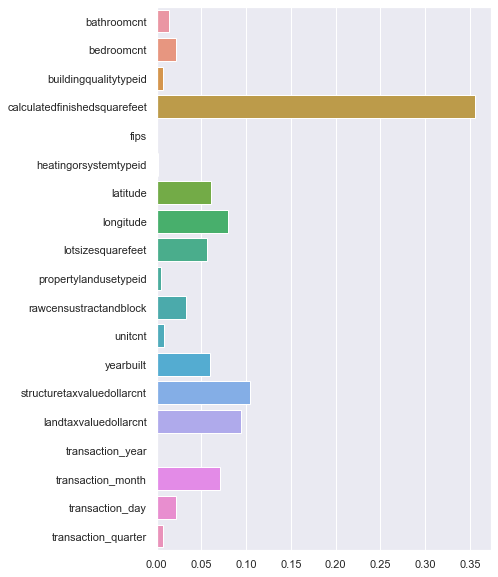

In [39]:
f, ax = plt.subplots(figsize=(6, 10))
sns.set_color_codes("pastel")
sns.barplot(x= rfcoeffeaturemags, y = rffeaturenames)

In [40]:
rsquared_RF = r2_score(y_test, y_predRF)
print('R Squared value using Random Forest = ', rsquared_RF)

R Squared value using Random Forest =  0.004371688626128134


In [44]:
MAEtrainlist = [mitrainmaebest, rfemaetrain, maelassotrain, rfmaetrain]
MAEtestlist = [mitestmaebest, rfemaetest, maelassotest, rfmaetest]

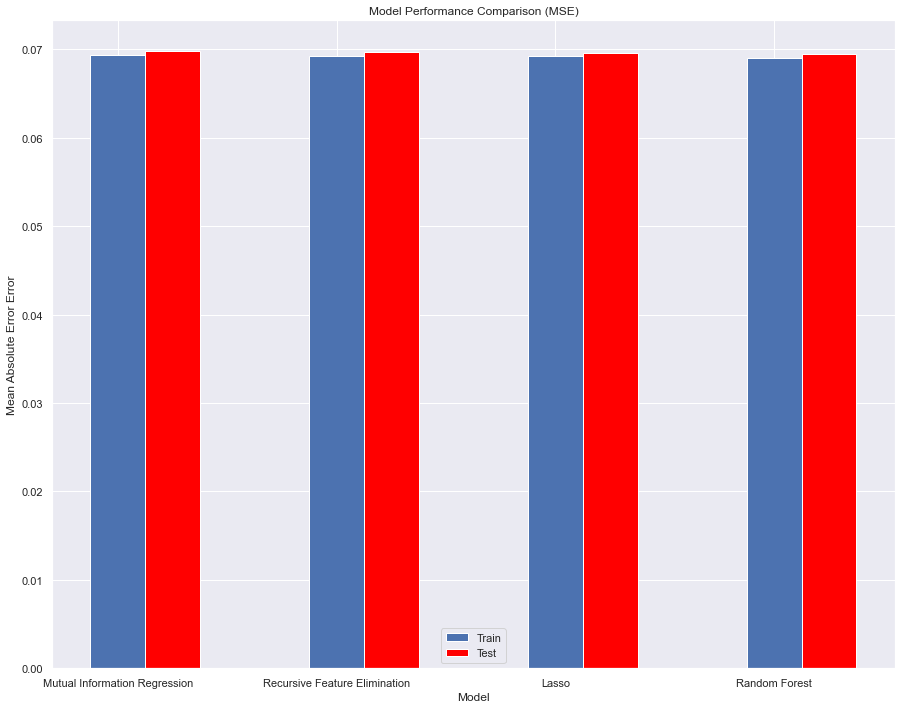

In [49]:
models = ['Mutual Information Regression', 'Recursive Feature Elimination', 'Lasso', 'Random Forest']
fig = plt.figure()
ind = np.arange(4)  
ax = fig.add_axes([0,0,1,1])
br1 = np.arange(len(MAEtrainlist))
br2 = [x + 0.25 for x in br1]
ax.bar(br1, MAEtrainlist, width = 0.25)
ax.bar(br2, MAEtestlist, color = 'red', width = 0.25)

plt.xlabel('Model')
plt.ylabel('Mean Absolute Error Error')

plt.legend(["Train", "Test"])
plt.title('Model Performance Comparison (MSE)')
plt.xticks(ind, models)
plt.show()


In [55]:
for i in range(len(models)):
     print(f"For the model {models[i]},  the mean ansolute error is {MAEtestlist[i]}")

For the model Mutual Information Regression,  the mean ansolute error is 0.06980574731375527
For the model Recursive Feature Elimination,  the mean ansolute error is 0.06967287690845514
For the model Lasso,  the mean ansolute error is 0.06961625200907737
For the model Random Forest,  the mean ansolute error is 0.06949202544000915


# Submission Creation!

In [ ]:
test_df['transactiondate'] = pd.Timestamp('2016-12-01') 
test_df = add_date_features(test_df)

In [ ]:
test_df

In [ ]:
submission = pd.DataFrame({
    'parcelid': test_df['parcelid'],
})
unavailables = ['parcelid', 'logerror']
test_df = test_df.drop(unavailables, axis = 1)
submission

In [ ]:
y_pred = RFmodel.predict(test_df)
sub = pd.read_csv('sample_submission.csv')
test_dates = {
    '201610': pd.Timestamp('2016-09-30'),
    '201611': pd.Timestamp('2016-10-31'),
    '201612': pd.Timestamp('2016-11-30'),
    '201710': pd.Timestamp('2017-09-30'),
    '201711': pd.Timestamp('2017-10-31'),
    '201712': pd.Timestamp('2017-11-30')
}


for label, test_date in test_dates.items():
    print("Predicting for: %s ... " % (label))
    submission[label] = y_pred
#for c in sub.columns[sub.columns != 'ParcelId']:
    #sub[c] = final_pred

submission.to_csv('submission.csv', index=False, float_format='%.4f') 
submission

In [ ]:
_ = tree.plot_tree(RFmodel.estimators_[0], feature_names=X_train.columns, filled=True)